- In regression problem, the aim is to predict the output of a continuous value, like price or pobability

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


- import dataset

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'   #Import data from url
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',           #For dataframe, give column names 
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,                   #Convert csv to pd with specific requirements
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)                        

In [3]:
dataset = raw_dataset.copy()
dataset.head() 

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


- clean data (Checking for NA)

In [4]:
dataset.isna().sum() #Check if any na or nan value is present in the df

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
#Drop rows with na
dataset = dataset.dropna()

- Origin column is a categorical value, not numeric. One-hot encoding with pd.get_dummies

In [6]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


- Seperating Origin column by value into column for each

In [7]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


## Split data into Train / Test sets

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)               #Seperate into 80/20
test_dataset = dataset.drop(train_dataset.index)

- Using seaborn to inspect Train Dataset

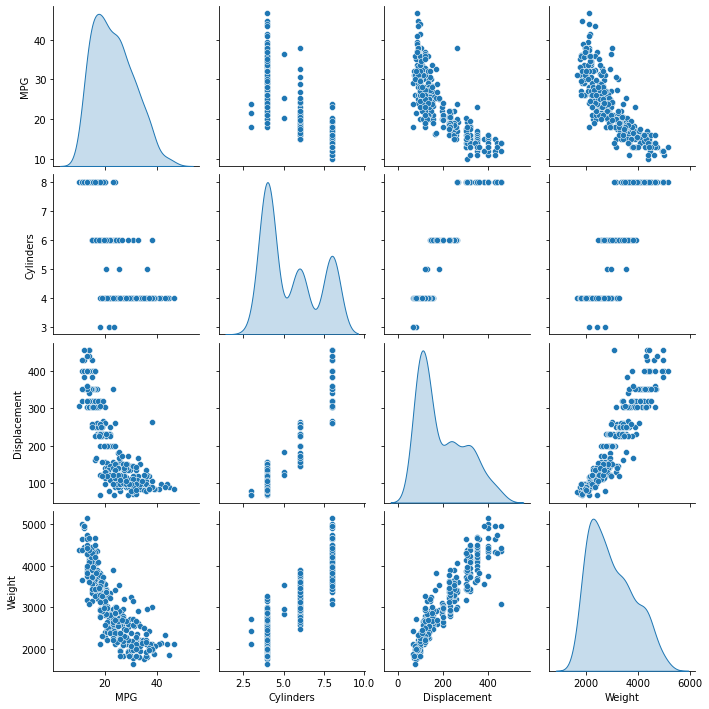

In [9]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

- Overall statistics of the training Dataset

In [10]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


- Seperate into Feature and labels

In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization
- Initially check range of features to check how they vary

In [12]:
train_dataset.describe().transpose()[['mean','std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


- One important reason normalization is important is because the features are multiplied by the model weights. Therefore, the scale of the outputs and scale of gradients is affected by scale of the inputs.
- A model 'might' converge without feature normalization, but it makes it more stable.

##### Normalization layer
- A Preprocessing layer which normalizes continuous features
- This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1.
- Calculates by precomputing the mean and variance of data, and calling *(input - mean) / sqrt(var)*


- The mean and variance values for the layer must be either supplied on construction or learned via **adapt()**

##### adapt()
- adapt() will compute the mean and variance of the data and store them as the layer's weights.
- Should be called before fit(), evaluate() or predict()

- Calling adapt() on a Normalization layer is an alternative to passing in 'mean' and 'variance' arguments during layer construction.
- A normalization layer should always be adapted over a dataset or pass 'mean' and 'variance' manually.

- During adapt(), the layer will compute 'mean' and 'variance' seperately for each position in each axis specified by 'axis' argument.
- if 'axis' == None, a single 'mean' and 'variance' will be calculated.


In [13]:
#First, create the layer
normalizer = tf.keras.layers.Normalization(axis=-1)

#Then, fit the state of the preprocessing layer to the data by calling
normalizer.adapt(np.array(train_features))

In [14]:
normalizer.mean.numpy()

array([[5.47770691e+00, 1.95318497e+02, 1.04869446e+02, 2.99025171e+03,
        1.55592356e+01, 7.58980942e+01, 1.78343967e-01, 1.97452217e-01,
        6.24203861e-01]], dtype=float32)

- #When the layer is called, it returns the input data -> with each feature independently normalized


In [17]:
#Trial
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Linear Regression

#### Linear regression with one variable

In [22]:
#Comparing 'MPG' and 'HorsePower'

#Required two steps: Normalize input feature and apply linear transormation

#Taking all Horsepower features
horsepower = np.array(train_features['Horsepower'])

#Normalize data
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)


- Apply a linear transformation (y=mx+b) to produce 1 output using a linear layer (tf.keras.layers.Dense)

In [24]:
#Build the keras Sequential model

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [26]:
#Compile Model
horsepower_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.1),
    loss = 'mean_absolute_error'
)

In [27]:
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=2,
    validation_split = 0.2)

Epoch 1/100
8/8 - 3s - loss: 22.8674 - val_loss: 22.9310 - 3s/epoch - 351ms/step
Epoch 2/100
8/8 - 0s - loss: 22.0624 - val_loss: 22.1310 - 105ms/epoch - 13ms/step
Epoch 3/100
8/8 - 0s - loss: 21.2630 - val_loss: 21.3310 - 100ms/epoch - 12ms/step
Epoch 4/100
8/8 - 0s - loss: 20.4631 - val_loss: 20.5310 - 96ms/epoch - 12ms/step
Epoch 5/100
8/8 - 0s - loss: 19.6673 - val_loss: 19.7313 - 85ms/epoch - 11ms/step
Epoch 6/100
8/8 - 0s - loss: 18.8640 - val_loss: 18.9311 - 89ms/epoch - 11ms/step
Epoch 7/100
8/8 - 0s - loss: 18.0639 - val_loss: 18.1314 - 78ms/epoch - 10ms/step
Epoch 8/100
8/8 - 0s - loss: 17.2640 - val_loss: 17.3313 - 80ms/epoch - 10ms/step
Epoch 9/100
8/8 - 0s - loss: 16.4629 - val_loss: 16.5312 - 81ms/epoch - 10ms/step
Epoch 10/100
8/8 - 0s - loss: 15.6644 - val_loss: 15.7314 - 96ms/epoch - 12ms/step
Epoch 11/100
8/8 - 0s - loss: 14.8655 - val_loss: 14.9314 - 73ms/epoch - 9ms/step
Epoch 12/100
8/8 - 0s - loss: 14.0625 - val_loss: 14.1314 - 77ms/epoch - 10ms/step
Epoch 13/100


In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802888,4.183835,95
96,3.805556,4.177346,96
97,3.802909,4.202287,97
98,3.806844,4.198290,98
99,3.804211,4.175700,99


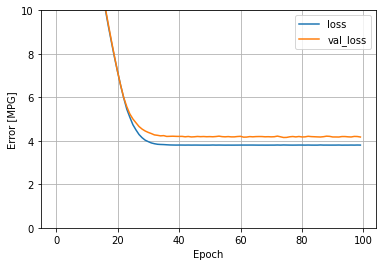

In [34]:
#Plot history loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)


In [35]:
# Collect the results on the test set
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=2
)

3/3 - 0s - loss: 3.6502 - 35ms/epoch - 12ms/step


In [38]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

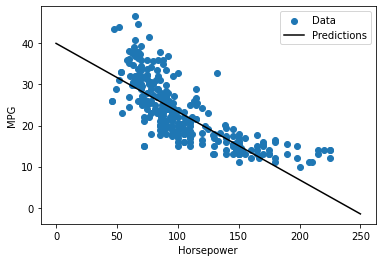

In [40]:
def plot_horsepower(x,y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

plot_horsepower(x,y)

# Regression with a deep neural network

- Single-input DNN
- Multiple-input DNN

- Layers to consider:
- Normalization layers (horsepower_normalizer)
- Two hidden, non-linear, Dense layer with ReLU activation
- a linear *Dense* single-output layer

In [41]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',
            optimizer=tf.keras.optimizers.Adam(0.001)
    )
    return model

#### Regression using a DNN and a single input
- 'Horsepower' as input
- horsepower_normalizer as normalization layer

In [42]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                128       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [43]:
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=1,epochs=100
)

Epoch 1/100
8/8 [==============================] - 1s 31ms/step - loss: 23.1164 - val_loss: 23.5007
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 22.8872 - val_loss: 23.2552
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 22.6456 - val_loss: 22.9776
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 22.3586 - val_loss: 22.6282
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 21.9799 - val_loss: 22.1628
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 21.4783 - val_loss: 21.5356
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 20.7965 - val_loss: 20.6963
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 19.8911 - val_loss: 19.5964
Epoch 9/100
8/8 [==============================] - 0s 16ms/step - loss: 18.7165 - val_loss: 18.1987
Epoch 10/100
8/8 [==============================] - 0s 15ms/step - loss: 17.2309 - val_loss: 16.4854

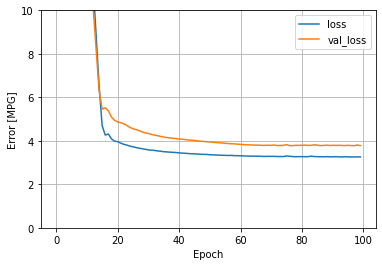

In [44]:
plot_loss(history)

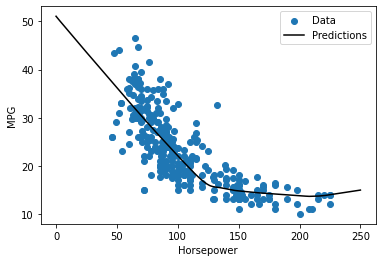

In [45]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x,y)

In [47]:
# Collec the results on the test set for later
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

In [49]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_4 (Dense)             (None, 64)                640       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


### Fit model

In [50]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=100
)

Epoch 1/100
8/8 [==============================] - 1s 49ms/step - loss: 23.2826 - val_loss: 23.5022
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 22.7575 - val_loss: 22.9688
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 22.70 - 0s 18ms/step - loss: 22.2387 - val_loss: 22.3705
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 21.6010 - val_loss: 21.5818
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 20.7517 - val_loss: 20.5185
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 19.6285 - val_loss: 19.0755
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 18.0545 - val_loss: 17.1809
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 16.0512 - val_loss: 14.6765
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 13.5340 - val_loss: 11.8885
Epoch 10/100
8/8 [==============================] - 0s 14ms/step - loss: 10.

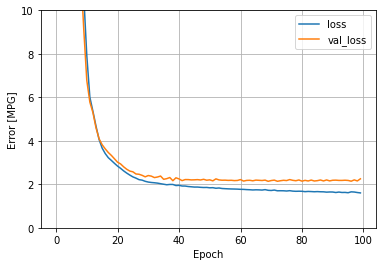

In [51]:
plot_loss(history)

In [52]:
# Collect results on the test set
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

In [53]:
#Since all models are now trained, lets review the performance
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.650204
dnn_horsepower_model,2.919378
dnn_model,1.641863


## Make prediction

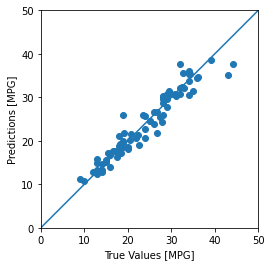

In [54]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### Error Distribution

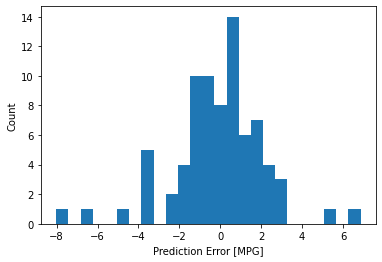

In [55]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

## Save and load model

In [56]:
dnn_model.save('dnn_model')
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

INFO:tensorflow:Assets written to: dnn_model\assets
